In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

ModuleNotFoundError: No module named 'google'

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


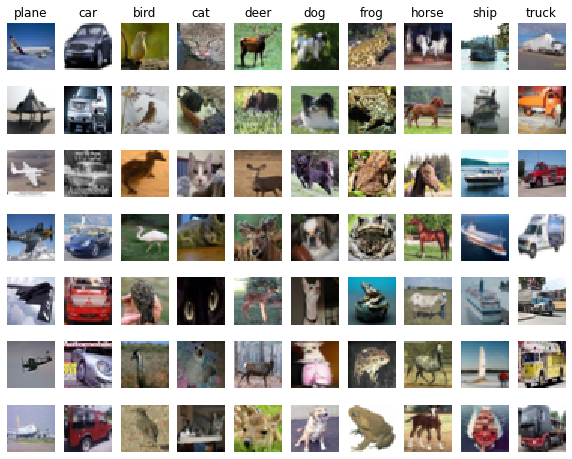

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]#用range分割矩阵
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)#随机选择
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


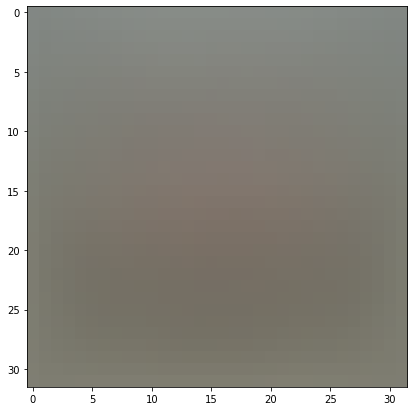

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)#按第一个索引值变化来求均值(按列求),默认返回行向量
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(7,7))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image#广播
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
#妙！
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.350171


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave（内插） your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -13.901073 analytic: -13.901073, relative error: 6.265838e-12
numerical: -19.279808 analytic: -19.279808, relative error: 1.068893e-11
numerical: 6.960121 analytic: 6.960121, relative error: 3.926976e-11
numerical: -18.538176 analytic: -18.538176, relative error: 2.325982e-11
numerical: -22.757186 analytic: -22.757186, relative error: 5.370787e-12
numerical: -0.021734 analytic: -0.021734, relative error: 9.503885e-09
numerical: -4.620670 analytic: -4.620670, relative error: 4.889155e-11
numerical: -10.167899 analytic: -10.167899, relative error: 1.428289e-11
numerical: -4.063143 analytic: -4.063143, relative error: 2.782701e-11
numerical: 10.938099 analytic: 10.938099, relative error: 1.364338e-11
numerical: -13.131654 analytic: -13.131654, relative error: 2.124657e-11
numerical: 0.369932 analytic: 0.366813, relative error: 4.234436e-03
numerical: -4.358070 analytic: -4.358070, relative error: 2.011515e-13
numerical: -28.777496 analytic: -28.767766, relative error: 1.690826e

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.350171e+00 computed in 0.129045s
Vectorized loss: 9.350171e+00 computed in 0.014986s
difference: -0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.130027s
Vectorized loss and gradient: computed in 0.006984s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 779.533497
iteration 100 / 1500: loss 285.979392
iteration 200 / 1500: loss 107.159491
iteration 300 / 1500: loss 42.628839
iteration 400 / 1500: loss 19.023064
iteration 500 / 1500: loss 9.840185
iteration 600 / 1500: loss 7.390979
iteration 700 / 1500: loss 5.953746
iteration 800 / 1500: loss 5.568512
iteration 900 / 1500: loss 6.080829
iteration 1000 / 1500: loss 5.311043
iteration 1100 / 1500: loss 5.524103
iteration 1200 / 1500: loss 5.608208
iteration 1300 / 1500: loss 5.862313
iteration 1400 / 1500: loss 5.276310
That took 7.203448s


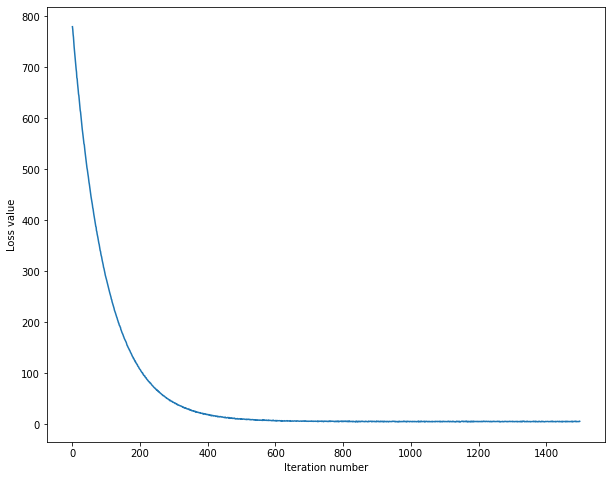

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set 检查过拟合程度？
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369163
validation accuracy: 0.383000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for l in np.linspace(learning_rates[0],learning_rates[-1],8):
    for r in np.linspace(regularization_strengths[0],regularization_strengths[-1],8):
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=l, reg=r,
                      num_iters=1000, verbose=True)
        train_acc = np.mean(y_train == svm.predict(X_train))
        val_acc = np.mean(y_val == svm.predict(X_val))        

        results[(l, r)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm   
#
#c，mb的，变量名一定不要取太长了！
#
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 798.041543
iteration 100 / 1000: loss 291.163387
iteration 200 / 1000: loss 109.057447
iteration 300 / 1000: loss 42.825046
iteration 400 / 1000: loss 18.855747
iteration 500 / 1000: loss 10.358589
iteration 600 / 1000: loss 7.270253
iteration 700 / 1000: loss 5.703324
iteration 800 / 1000: loss 5.386947
iteration 900 / 1000: loss 5.083664
iteration 0 / 1000: loss 889.938958
iteration 100 / 1000: loss 282.466394
iteration 200 / 1000: loss 92.732368
iteration 300 / 1000: loss 33.212238
iteration 400 / 1000: loss 14.084671
iteration 500 / 1000: loss 8.733241
iteration 600 / 1000: loss 6.620501
iteration 700 / 1000: loss 5.795030
iteration 800 / 1000: loss 5.294702
iteration 900 / 1000: loss 5.784167
iteration 0 / 1000: loss 1006.951570
iteration 100 / 1000: loss 276.146504
iteration 200 / 1000: loss 79.427551
iteration 300 / 1000: loss 25.230512
iteration 400 / 1000: loss 11.380222
iteration 500 / 1000: loss 6.871071
iteration 600 / 1000: loss 5.829229
iteration 

iteration 200 / 1000: loss 355.082299
iteration 300 / 1000: loss 321.884390
iteration 400 / 1000: loss 429.664205
iteration 500 / 1000: loss 394.180293
iteration 600 / 1000: loss 484.170893
iteration 700 / 1000: loss 348.095063
iteration 800 / 1000: loss 314.817992
iteration 900 / 1000: loss 410.624744
iteration 0 / 1000: loss 1547.658291
iteration 100 / 1000: loss 457.451369
iteration 200 / 1000: loss 427.283322
iteration 300 / 1000: loss 539.523935
iteration 400 / 1000: loss 479.690174
iteration 500 / 1000: loss 497.457930
iteration 600 / 1000: loss 534.960048
iteration 700 / 1000: loss 427.405061
iteration 800 / 1000: loss 523.877143
iteration 900 / 1000: loss 451.057582
iteration 0 / 1000: loss 796.353022
iteration 100 / 1000: loss 256.736227
iteration 200 / 1000: loss 260.763273
iteration 300 / 1000: loss 245.291221
iteration 400 / 1000: loss 302.702293
iteration 500 / 1000: loss 304.223390
iteration 600 / 1000: loss 291.958144
iteration 700 / 1000: loss 299.803194
iteration 800 /

iteration 700 / 1000: loss 262207303295477335800743774552416710372626443647388121718533727157038077270225414339671426849219046452104975742555175201262028600711668554709626858915825494168975888238549623000240116280487025896068074314694755114195752284365783040.000000
iteration 800 / 1000: loss 70961945205731683768319887746416963952814942435892677677458912631938689701167370849549666274826825941250003582119510995098400665256236678848011990096994606329294025698187545383070017795655470476279827715031797646070953024257301363448594648609740157037446252462080.000000
iteration 900 / 1000: loss 19204643059490715506079032728230039320287225311375361415878846230689576521177037145923867327803308272502586678866325405442595821947991110269071111040079844962639709083854466596488452474070961363044913640875211266023587351074477655289021948243196991515895385856371225006410411164396255034822623232.000000


C:\Users\南城图书馆\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:103: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
D:\anaconda3\envs\cs231n\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\南城图书馆\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:103: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 0 / 1000: loss 1448.024354
iteration 100 / 1000: loss 159224624820993290575487632539965342622261706752.000000
iteration 200 / 1000: loss 11712550000310923482537531301984309515878463228759076008977543022237029220103399654845054976.000000
iteration 300 / 1000: loss 861574192208089362386980286464737925703914069651044033244136202027094781688079418165184119966340853548014388438773906721763755611389952.000000
iteration 400 / 1000: loss 63377325062374685383102040664040115429756926462996801649940944160421033756107448196673891439544662292972425342306912008062740853970907914077674264729674682934907812628332598525952.000000
iteration 500 / 1000: loss 4662030697284146374312323054156684638322649264072907013880892772422285731147872719488820638430001221861686008005219417860369927319779017188372737809504485430455295196746877935455969093571242616333447702917152633572892344320.000000
iteration 600 / 1000: loss 342938585701258720590425223521568044388623183677036429219546182755258896437791192063

iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf


C:\Users\南城图书馆\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:96: RuntimeWarning: overflow encountered in subtract
  margins = scores - correct_scores + 1.0#减scores和加1.0时均使用广播
C:\Users\南城图书馆\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:98: RuntimeWarning: invalid value encountered in multiply
  margins *= (margins > 0)#对应margins[margins <= 0] = 0.0
C:\Users\南城图书馆\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:134: RuntimeWarning: overflow encountered in multiply
  dW += X.T.dot(margins)/num_train + 2*reg*W


iteration 0 / 1000: loss 1464.691120
iteration 100 / 1000: loss 19762072772020600475282579633769239636254827865333112592640667021384286732288.000000
iteration 200 / 1000: loss 226578044403127408744314760395269325785343150712935398896008894608969475292017361669787723597079512315683359689421936542417979266108639570881299873792.000000
iteration 300 / 1000: loss 2597784695855893523340990362905918140630403191768316000748930846383665988838233925855772842876288675613658323985825136233939952048474219457144894346902278049849973581402322193196654979597056728759170413584744610625581219840.000000
iteration 400 / 1000: loss 29784374491361582180394074990683861913844263337947416334488851408494054990652218459984507559086192019850207161990094191872676982752176722977358949201851964429864210962375160950641768214046991873278676194274171671593891253680856711525916962917244819199859965102184656194289114609220256106689855488.000000
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 /

C:\Users\南城图书馆\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:96: RuntimeWarning: invalid value encountered in subtract
  margins = scores - correct_scores + 1.0#减scores和加1.0时均使用广播


iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1569.669254
iteration 100 / 1000: loss 22996568455165070360264477857637040353968821898796318918195500384407040670807403528192.000000
iteration 200 / 1000: loss 311180490658977896981987773160339228036119894913373352166036391632329217197139574366539845088444645961029443402306169530410440195949071855894717155562604719974398296064.000000
iteration 300 / 1000: loss 4210771618189551953421425625565618956638303245458711202055254278243202723982170994632409307471445938888249874381030039372694132666712755617012215024942673669166457782546849223718624259835892384445895401666314964907606592010155318184971332501830107136.000000
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 789.604021
iteration 100 / 1000: loss 6866754347247471.000000
iteration 200 / 1000: loss 30861143371554526334487

iteration 300 / 1000: loss 648815974319154830088297330826919414307078159903370425344670610974583575634816283622070069974834778245129070274530886971078934601406087927706238487518269507758968528082017138141678966936875237605225142236489767398133782796410069802095411901246360690884862775901839012436163017466034782208.000000
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1563.185632
iteration 100 / 1000: loss 40266854963013503770773003933612951111257928609560721651531211619218237071375276889987013319754917286510592.000000
iteration 200 / 1000: loss 930386588241651306376297827673005286588119535410048372965657397083877845185667090756381655648637258200178495575709808058594846986180645959569634950035277344948467007492708665771001890466219917384479760332095488.000000
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
itera

iteration 200 / 1000: loss 11271366095355024885079253323091607140346372839299879335612083507934852907529915713674169200524096658591702136894341402599299807254260015341845953721195379794972138369248867097733270960869023196214726112986320388706104641631133795714397869441024.000000
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.364837 val accuracy: 0.374000
lr 1.000000e-07 reg 2.857143e+04 train accuracy: 0.353143 val accuracy: 0.356000
lr 1.000000e-07 reg 3.214286e+04 train accuracy: 0.367306 val accuracy: 0.363000
lr 1.000000e-07 reg 3.571429e+04 train accuracy: 0.361551 val accuracy: 0.377000
lr 1.000000e-07 reg 3.928571e+04 train accuracy: 0.359327 val accuracy: 0.367000
lr 1.000000e-07 reg 4.285714e+04 train accuracy: 0.353816 val accuracy: 0.352000
lr 1.000000e-07 r

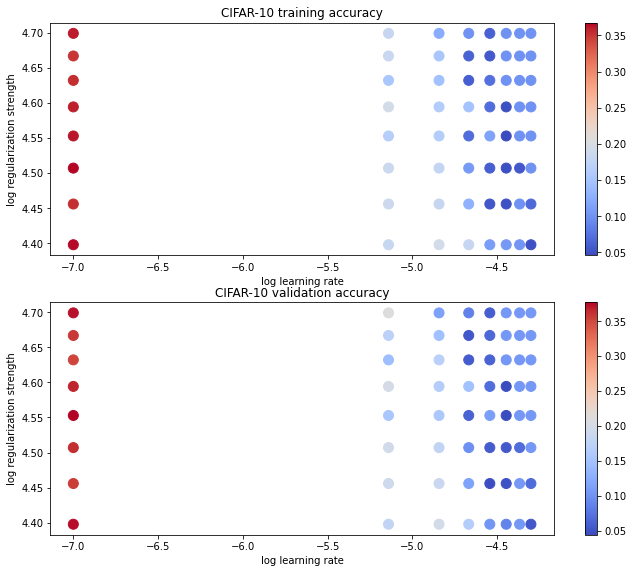

In [17]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


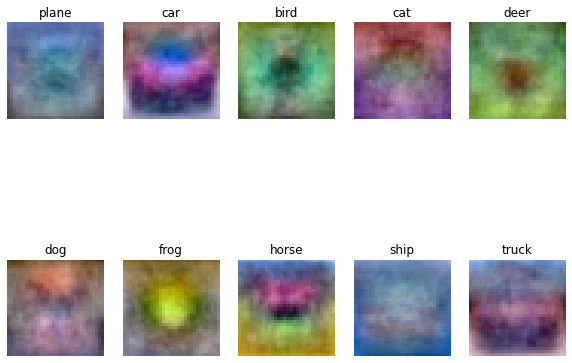

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
